In [1]:
import torch
from torch import Tensor
import transformer_lens
import transformer_lens.utils as utils
from transformer_lens.hook_points import (
    HookedRootModule,
    HookPoint,
)  # Hooking utilities
from transformer_lens import HookedTransformer, HookedTransformerConfig, FactoredMatrix, ActivationCache
import numpy as np
import torch as t
import tqdm
#functional
import torch.nn.functional as F
import matplotlib.pyplot as plt
import plotly.io as pio
import plotly.express as px
import plotly.graph_objects as go
from functools import partial
import einops
import circuitsvis as cv
from src.game import Board, apply_best_moves, get_best_moves, generate_all_games

# Graphing stuff

In [2]:
def to_numpy(tensor, flat=False):
    if type(tensor)!=torch.Tensor:
        return tensor
    if flat:
        return tensor.flatten().detach().cpu().numpy()
    else:
        return tensor.detach().cpu().numpy()

def imshow(tensor, xaxis=None, yaxis=None, animation_name='Snapshot', **kwargs):
    tensor = torch.squeeze(tensor)
    px.imshow(to_numpy(tensor, flat=False),aspect='auto', 
              labels={'x':xaxis, 'y':yaxis, 'animation_name':animation_name}, 
              **kwargs).show()
# Set default colour scheme
imshow = partial(imshow, color_continuous_scale='Blues')
# Creates good defaults for showing divergent colour scales (ie with both 
# positive and negative values, where 0 is white)
imshow_div = partial(imshow, color_continuous_scale='RdBu', color_continuous_midpoint=0.0)
# Presets a bunch of defaults to imshow to make it suitable for showing heatmaps 
# of activations with x axis being input 1 and y axis being input 2.
inputs_heatmap = partial(imshow, xaxis='Input 1', yaxis='Input 2', color_continuous_scale='RdBu', color_continuous_midpoint=0.0)

def line(x, y=None, hover=None, xaxis='', yaxis='', **kwargs):
    if type(y)==torch.Tensor:
        y = to_numpy(y, flat=True)
    if type(x)==torch.Tensor:
        x = to_numpy(x, flat=True)
    fig = px.line(x, y=y, hover_name=hover, **kwargs)
    fig.update_layout(xaxis_title=xaxis, yaxis_title=yaxis)
    fig.show()

def lines(lines_list, x=None, mode='lines', labels=None, xaxis='', yaxis='', title = '', log_y=False, hover=None, **kwargs):
    if type(lines_list)==torch.Tensor:
        lines_list = [lines_list[i] for i in range(lines_list.shape[0])]
    if x is None:
        x=np.arange(len(lines_list[0]))
    fig = go.Figure(layout={'title':title})
    fig.update_xaxes(title=xaxis)
    fig.update_yaxes(title=yaxis)
    for c, line in enumerate(lines_list):
        if type(line)==torch.Tensor:
            line = to_numpy(line)
        if labels is not None:
            label = labels[c]
        else:
            label = c
        fig.add_trace(go.Scatter(x=x, y=line, mode=mode, name=label, hovertext=hover, **kwargs))
    if log_y:
        fig.update_layout(yaxis_type="log")
    fig.show()

# Training Config Stuff

In [3]:
cfg = HookedTransformerConfig(
    n_layers = 8,
    n_heads = 8,
    d_model = 128,
    d_head = 16,
    d_mlp = 512,
    act_fn = "relu",
    normalization_type=None,
    d_vocab=11,
    d_vocab_out=10,
    n_ctx=10,
    init_weights=True,
    device="cuda",
    seed = 1337,
)

lr = 1e-4
weight_decay = 1e-4
test_train_split = 0.8
epochs = 10
batch_size = 8192



In [5]:
boards = [Board()]
game_list = apply_best_moves(boards)

we're on the 1th loop!


ValueError: Not a valid move nerd!!

In [4]:
boards = [Board()]
game_list = apply_best_moves(boards)
moves = np.array([[10] + game.moves_played + [9] for game in game_list])

we're on the 1th loop!


ValueError: Not a valid move nerd!!

In [6]:
boards = [Board()]
game_list = generate_all_games(boards)
moves = np.array([[10] + game.moves_played + ([9] * (cfg.n_ctx - len(game.moves_played))) for game in game_list])

In [7]:
print(moves[0])

[10  0  1  3  2  6  9  9  9  9  9]


In [20]:
boards = [Board()]
game_list = apply_best_moves(boards)
moves = np.array([game.moves_played + [9] for game in game_list])

we're on the 1th loop!


ValueError: Not a valid move nerd!!

In [8]:
boards = [Board()]
game_list = generate_all_games(boards)

In [9]:
len(game_list)

255168

In [8]:
#load npy file
# np_data = np.load('data/moves.npy')
data = moves[:, :-1]
labels = moves[:, 1:]

print(len(data))
print(len(labels))
print(data[0])
print(labels[0])

255168
255168
[10  0  1  3  2  6  9  9  9  9]
[0 1 3 2 6 9 9 9 9 9]


In [11]:
encoded_labels = F.one_hot(t.tensor(labels))

In [12]:
encoded_data = F.one_hot(t.tensor(data))
print(encoded_data[1238])

tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]])


In [13]:
encoded_labels[0,:,:]

tensor([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]])

In [14]:
#data and labels as numpy arrays
data = np.array(data)
encoded_labels = np.array(encoded_labels)
#data and encoded_labels as tensors
data = t.from_numpy(data)
encoded_labels = t.from_numpy(encoded_labels).to(t.float)
total_data = list(zip(data, encoded_labels))
num_samples = len(total_data)
train_size = int(test_train_split * num_samples)
test_size = num_samples - train_size
split_data = list(t.utils.data.random_split(total_data, [train_size, test_size]))
train_pairs = split_data[0]
test_pairs= split_data[1]
train_data, train_labels = zip(*train_pairs)
test_data, test_labels = zip(*test_pairs)

train_data = t.stack(train_data).to(cfg.device)
train_labels = t.stack(train_labels).to(cfg.device)
test_data = t.stack(test_data).to(cfg.device)
test_labels = t.stack(test_labels).to(cfg.device)



#test train split
train_data = data[:int(len(data)*test_train_split)]
train_labels = encoded_labels[:int(len(data)*test_train_split)]
test_data = data[int(len(data)*test_train_split):]
test_labels = encoded_labels[int(len(data)*test_train_split):]

In [15]:
def loss_fn(logits: Tensor, labels: Tensor):
    return t.nn.functional.cross_entropy(logits, labels)

In [20]:
def seq_is_matched(input: list[int], seq: list[int]) -> bool:
    return all(seq[i] == input[i] for i in range(len(seq)))

In [21]:
[seq for seq in seqs if seq_is_matched(seq, [4])]

NameError: name 'seqs' is not defined

In [16]:
train_losses = []
test_losses = []
# ALPHATOE
model = HookedTransformer(cfg).to(cfg.device)
optimizer = t.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

# for epoch in tqdm.tqdm(range(epochs)):
for epoch in range(epochs):
    for batch in range(0, len(train_data), batch_size):
        train_logits = model(train_data[batch:batch+batch_size])
        train_loss = loss_fn(train_logits, train_labels[batch:batch+batch_size])

        train_loss.backward()

        train_losses.append(train_loss.item())
        optimizer.step()
        optimizer.zero_grad()

        with t.inference_mode():
            test_logits = model(test_data)
            test_loss = loss_fn(test_logits, test_labels)
            test_losses.append(test_loss.item())

        print(f"Epoch {epoch} | Train Loss: {train_loss.item()} | Test Loss: {test_loss.item()}")

Moving model to device:  cuda
Epoch 0 | Train Loss: 2.8080050945281982 | Test Loss: 2.3766825199127197
Epoch 0 | Train Loss: 2.37743878364563 | Test Loss: 2.243098497390747
Epoch 0 | Train Loss: 2.242861270904541 | Test Loss: 2.147594690322876
Epoch 0 | Train Loss: 2.1462807655334473 | Test Loss: 2.0750679969787598
Epoch 0 | Train Loss: 2.0747716426849365 | Test Loss: 2.017258405685425
Epoch 0 | Train Loss: 2.0150792598724365 | Test Loss: 1.9754102230072021
Epoch 0 | Train Loss: 1.9754637479782104 | Test Loss: 1.9378716945648193
Epoch 0 | Train Loss: 1.9352155923843384 | Test Loss: 1.8938804864883423
Epoch 0 | Train Loss: 1.8929462432861328 | Test Loss: 1.8461593389511108
Epoch 0 | Train Loss: 1.8454378843307495 | Test Loss: 1.801153540611267
Epoch 0 | Train Loss: 1.798885703086853 | Test Loss: 1.7607389688491821
Epoch 0 | Train Loss: 1.7615665197372437 | Test Loss: 1.719709038734436
Epoch 0 | Train Loss: 1.7215832471847534 | Test Loss: 1.6757651567459106
Epoch 0 | Train Loss: 1.675653

In [ ]:
train_labels[0]

tensor([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]], device='cuda:0')

In [37]:
seq_test = [10,3,1,7]
print(t.max(model(t.tensor(seq_test))[0, -1]))
print(t.argmax(model(t.tensor(seq_test))[0, -1]))
print(model(t.tensor(seq_test))[0, -1].shape)



tensor(20.2244, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(3, device='cuda:0')
torch.Size([10])


In [20]:
lines([test_losses, train_losses])

(0.0, 100.0)

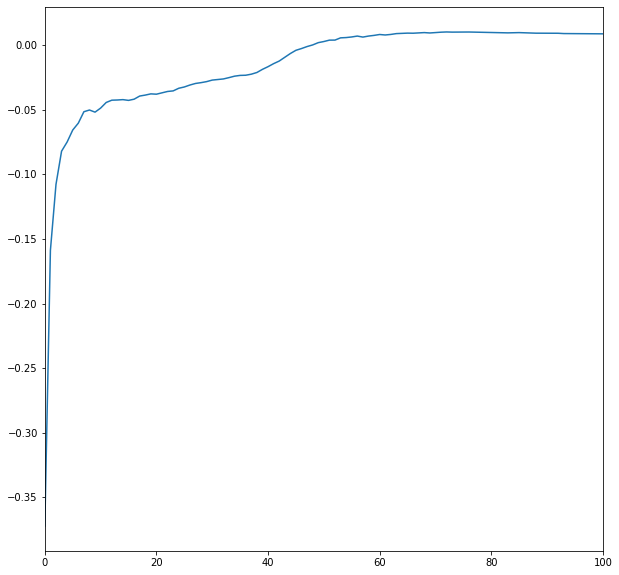

In [ ]:
#difference of lists test_losses and train_losses
diff = [test_losses[i] - train_losses[i] for i in range(len(test_losses))]
plt.figure(figsize=(10, 10))
plt.plot(diff)
#xlim
plt.xlim(0, 100)

In [ ]:
seq = t.tensor([10] * 10).to(cfg.device)
out = model(seq)

In [ ]:
out[:,-1,:]

tensor([[-68.5691, -53.3248, -33.7109,  28.4673, -47.1521,  49.8403,  20.7787,
          18.6870, -19.6562,  14.9037]], device='cuda:0',
       grad_fn=<SliceBackward0>)

In [ ]:
line(test_losses, log_y=True)
# plt.plot(train_losses)

In [ ]:
line(train_losses, log_y=True)

In [17]:
imshow(model.embed.W_E)

In [18]:
# Take the dot product of all the embedding vectors
emb = model.embed.W_E
vec_count = emb.shape[0]
vec_dim = emb.shape[1]
print(f"The embedding shape is {emb.shape}, so our vectors of length {emb.shape[1]}")

dot_products = einops.einsum(emb, emb, "v2 embs, v1 emb -> v1 v2")

The embedding shape is torch.Size([11, 128]), so our vectors of length 128


In [19]:
print(dot_products.shape)
imshow_div(dot_products)

torch.Size([11, 11])


## What would your hypothesis around the attention head activations be based on seeing this?
+ Jack - My poorly informed guess is that tokens with low dot products and/or low norms won't have any strong attentional interaction
+ Omar - I think that corner moves [0, 2, 6, 8] will have similar attention patterns
+ Ari - I think same as Omar, plus center attends to everything, middle edges have attention symmetry too

In [54]:
tokens = [10,0,2]
# tokens = ([10] * 5) + [1,2,5,8,7]
str_tokens = [str(token) for token in tokens]
logits, cache = model.run_with_cache(torch.tensor(tokens).to('cuda'), remove_batch_dim=True)

print(type(cache))
attention_pattern = cache["pattern", 3, "attn"]
print(attention_pattern.shape)
cv.attention.attention_patterns(tokens=str_tokens, attention=attention_pattern)

<class 'transformer_lens.ActivationCache.ActivationCache'>
torch.Size([8, 3, 3])
